# <header>**Baseline model for Automated Essay Scoring competition**</header>

*Version 0.1*

In [10]:
!pip install torchview
!pip install torchinfo

^C


# Utils

In [11]:
import random
from kaggle_secrets import UserSecretsClient
import wandb
import os
import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation, printable
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

import torch
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchview import draw_graph
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from transformers import AutoModel, AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_ha")

wandb.login(key=wandb_api)


random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

cpu


In [ ]:
model_path = 'allenai/longformer-base-4096'
tokenizer = AutoTokenizer.from_pretrained(model_path)
embedder = AutoModel.from_pretrained(model_path)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
ling_features = ['num_punctuations', 'num_nouns',
                 'num_verbs', 'num_adverbs', 'num_conjunctions',
                 'num_distinct_words', 'num_misspell',
                 'mean_word_len', 'num_sentences', 'mean_sent_len']

In [13]:
data_dir = "../../output/"

train_data = pd.read_csv(data_dir + 'train_linguistic.csv')
extra_data = pd.read_csv(data_dir + 'extra_linguistic.csv')

train_data = train_data.dropna(subset=['full_text'])
extra_data = extra_data.dropna(subset=['full_text'])

train_data = train_data[['essay_id', 'full_text', 'score'] + ling_features]
extra_data = extra_data[['essay_id', 'full_text', 'score'] + ling_features]

extra_data = extra_data[~extra_data['full_text'].isin(train_data['full_text'])]

print(train_data.shape, extra_data.shape)

train_data.sample(5)


(17307, 13) (13125, 13)


,essay_id,full_text,score,num_punctuations,num_nouns,num_verbs,num_adverbs,num_conjunctions,num_distinct_words,num_misspell,mean_word_len,num_sentences,mean_sent_len
12696,bb4c434,"People tend to use there cars so much, they ba...",3,36,113,81,43,26,211,20,3.905263,26,113.076923
4625,44e88b0,Imagine being a top scientist at NASA and Viki...,3,58,93,40,12,10,180,8,4.342391,22,94.954545
733,0ba78ec,The face of Mars could not be created by alien...,3,17,46,15,13,9,114,5,4.267857,12,101.583333
16885,f96c287,Many people belive that the face on Mars was c...,3,26,53,29,10,6,163,26,4.290984,13,104.461538
3334,317173f,Driverless Cars are coming soon or later? Peop...,4,38,114,83,29,39,168,8,4.028099,31,100.129032


In [ ]:
def preprocess(text):
    # text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = ''.join([c for c in text if c in printable])
    text = text.strip()
    return text

train_data['full_text'] = train_data['full_text'].apply(preprocess)
extra_data['full_text'] = extra_data['full_text'].apply(preprocess)

train_data.sample(5)

Venus is a dangerous but why should that stop us. Astronomers are fascinated by Venus because it may well once have been the most earth- like planet in our solar system. Long ago. Venus was probably covered largely with oceans and could have supported various forms of life, just like Earth. This means that we might of had something similar like our earth today (Para 4). This is why we have to explore Venus and see what new things we can learn about it. We can figure new things out about Venus if we try. Therefore, scientists seeking to conduct a thorough misson to understand Venus would need to get up close and personal despite the risk. Or maybe we should think of them as challenges (Para 6). This means we have to take risk to know Venus more. We have to try and be willing to do what it takes to get information about Venus. By doing what we need to do to know Venus more will be hard. Our travels on earth and beyond should not be limited by dangers and doubts but should be expanded to 

Split train, val, test set

In [18]:
extra_ids = extra_data['essay_id'].values

total_len = len(train_data) + len(extra_data)

train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

train_len = int(total_len * train_ratio)
train_df = pd.concat([train_data, extra_data.sample(
    train_len - len(train_data), random_state=random_seed)], ignore_index=True)
train_df = train_df.reset_index(drop=True)

val_len = int(total_len * val_ratio)
val_df = extra_data[~extra_data['essay_id'].isin(
    train_df['essay_id'])].sample(val_len, random_state=random_seed)
val_df = val_df.reset_index(drop=True)

test_df = extra_data[~extra_data['essay_id'].isin(
    set(val_df['essay_id']).union(set(train_df['essay_id'])))]
test_df = test_df.reset_index(drop=True)

print(train_df.shape, val_df.shape, test_df.shape)

(24345, 13) (3043, 13) (3043, 13)


Hyperparameters

In [9]:
hyperparameters = {
    'lr': 5e-4,
    'dropout': 0.2,
    'epochs': 5,
    'batch_size': 36,
    'embedding_model': model_path,
    'train_set': {
        'total': len(train_df),
        'ratio': train_ratio,
    },
    'val_set': {
        'total': len(val_df),
        'ratio': val_ratio,
    },
    'test_set': {
        'total': len(test_df),
        'ratio': test_ratio,
    },
    'linguistic_features': ling_features,
    'accelator': str(device)
}

In [10]:
train_tokenized = tokenizer(train_df['clean_text'].tolist(),
                                  padding=True, truncation=False, return_tensors="np")

train_df['input_ids'] = train_tokenized['input_ids'].tolist()
train_df['attention_mask'] = train_tokenized['attention_mask'].tolist()

hyperparameters['max_seq_len'] = train_tokenized['input_ids'].shape[1]
print(hyperparameters['max_seq_len'])

print(len(train_df.sample(1).iloc[0]['input_ids']))

1850
1850


In [11]:
val_tokenized = tokenizer(val_df['clean_text'].tolist(),
                                max_length=hyperparameters['max_seq_len'], padding='max_length',
                                truncation=True, return_tensors="pt")

val_df['input_ids'] = val_tokenized['input_ids'].tolist()
val_df['attention_mask'] = val_tokenized['attention_mask'].tolist()

print(len(val_df.sample(1).iloc[0]['input_ids']))

test_tokenized = tokenizer(test_df['clean_text'].tolist(),
                                max_length=hyperparameters['max_seq_len'], padding='max_length',
                                truncation=True, return_tensors="pt")

test_df['input_ids'] = test_tokenized['input_ids'].tolist()
test_df['attention_mask'] = test_tokenized['attention_mask'].tolist()

print(len(test_df.sample(1).iloc[0]['input_ids']))

1850
1850


In [12]:
class MultiFeaturesDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        # self.text = df['clean_text'].values
        self.token_ids = df['input_ids'].values
        self.attention_mask = df['attention_mask'].values
        self.score = df['score'].values
        self.ling_features = []
        for feature in ling_features:
            self.ling_features.append(df[feature].values)

    def __len__(self):
        return len(self.score)

    def __getitem__(self, idx):
        features = []
        for feature in self.ling_features:
            features.append(feature[idx])
        
        features = torch.tensor(features, dtype=torch.float)

        score = torch.reshape(torch.tensor(self.score[idx], dtype=torch.float), (1,))
        
        return torch.tensor(self.token_ids[idx]), torch.tensor(self.attention_mask[idx]), features, score

train_dataset = MultiFeaturesDataset(train_df)
val_dataset = MultiFeaturesDataset(val_df)
test_dataset = MultiFeaturesDataset(test_df)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

for token_ids, attention_mask, features, score in train_dataloader:
    print(token_ids.shape, attention_mask.shape, features.shape, score.shape)
    break

torch.Size([32, 1850]) torch.Size([32, 1850]) torch.Size([32, 9]) torch.Size([32, 1])


In [14]:
class MultiFeaturesModel(torch.nn.Module):
    def __init__(self, embedder, ling_features_size, dropout=0.2):
        super(MultiFeaturesModel, self).__init__()
        # freeze
        for param in embedder.parameters():
            param.requires_grad = False
        self.embedder = embedder
        self.ling_features_size = ling_features_size
        self.ling_features = torch.nn.Linear(ling_features_size, 64)
        self.regressor = torch.nn.Linear(64 + embedder.config.hidden_size, 1)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, token_ids, attention_mask, ling_features):
        embedded = self.embedder(
            token_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        embedded = self.dropout(embedded)
        ling_features = torch.relu(self.ling_features(ling_features))
        ling_features = self.dropout(ling_features)
        features = torch.cat((embedded, ling_features), dim=1)
        score = self.regressor(features)
        return score


model = MultiFeaturesModel(embedder, len(
    ling_features), hyperparameters['dropout'])

inputs = next(iter(train_dataloader))[:-1]
model_summary = summary(model, input_data=inputs)

model_summary

Input ids are automatically padded from 1850 to 2048 to be a multiple of `config.attention_window`: 512


Layer (type:depth-idx)                                       Output Shape              Param #
MultiFeaturesModel                                           [32, 1]                   --
├─LongformerModel: 1-1                                       [32, 768]                 --
│    └─LongformerEmbeddings: 2-1                             [32, 2048, 768]           --
│    │    └─Embedding: 3-1                                   [32, 2048, 768]           (38,603,520)
│    │    └─Embedding: 3-2                                   [32, 2048, 768]           (3,147,264)
│    │    └─Embedding: 3-3                                   [32, 2048, 768]           (768)
│    │    └─LayerNorm: 3-4                                   [32, 2048, 768]           (1,536)
│    │    └─Dropout: 3-5                                     [32, 2048, 768]           --
│    └─LongformerEncoder: 2-2                                [32, 1850, 768]           --
│    │    └─ModuleList: 3-6                                  --     

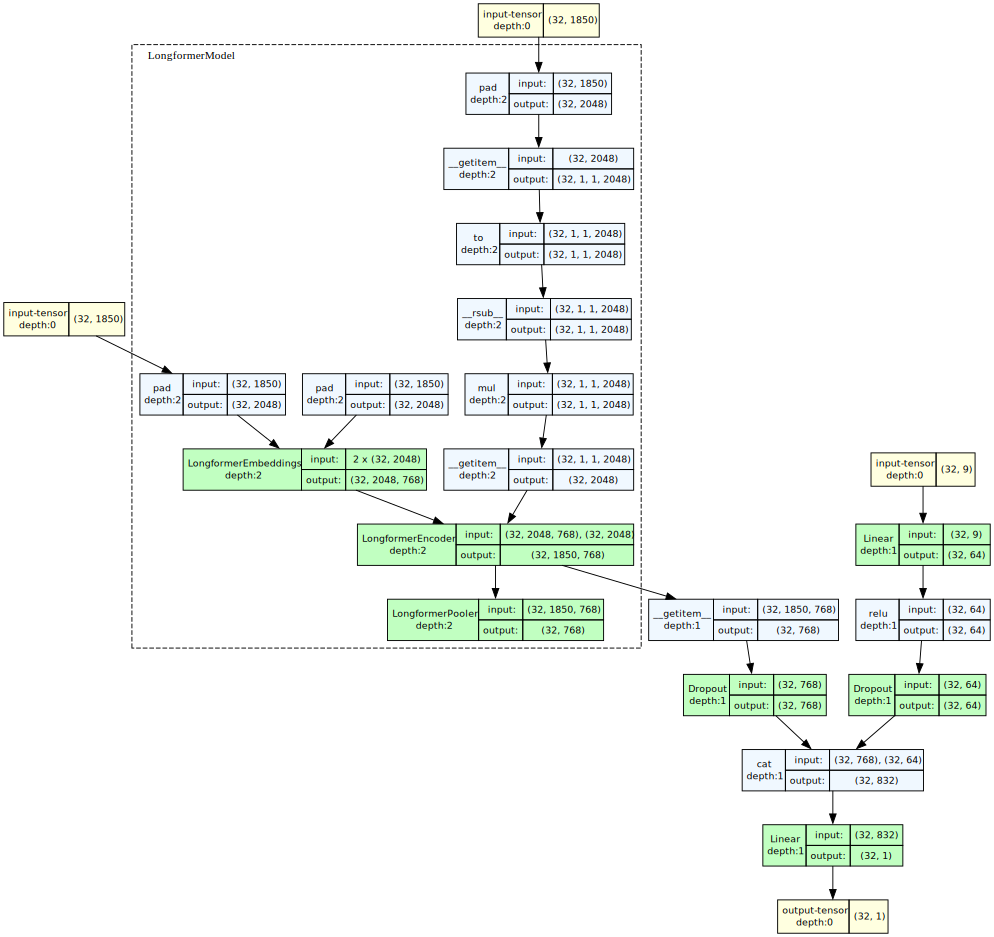

In [15]:
model_graph = draw_graph(model, 
                         input_data=inputs,
                         expand_nested=True,
                         depth=2)
model_graph.visual_graph

In [16]:
def train(model, optimizer, criterion, train_dataloader, logging_steps=10):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (token_ids, attention_mask, features, score) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(token_ids.to(device), attention_mask.to(
            device), features.to(device))
        loss = criterion(output, score.to(device)).float()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (i+1) % logging_steps == 0:
            wandb.log({'train_loss': running_loss / (i+1)})
            print(
                f'Batch {i+1}/{len(train_dataloader)} Loss: {running_loss / (i+1)}', end='\r')

    return running_loss / len(train_dataloader)


def evaluate(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_scores = []

    with torch.no_grad():
        for token_ids, attention_mask, features, score in dataloader:
            output = model(token_ids.to(device), attention_mask.to(
                device), features.to(device))
            loss = criterion(output, score.to(device))
            kappa = cohen_kappa_score(np.round(
                output.cpu().numpy()), np.round(score.cpu().numpy()))
            running_loss += loss.item()
            all_predictions.extend(output.cpu().numpy())
            all_scores.extend(score.cpu().numpy())

    return running_loss / len(dataloader), np.array(all_predictions), np.array(all_scores)

In [17]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [18]:
critierion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=hyperparameters['lr'])
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
early_stopper = EarlyStopper(patience=3, min_delta=1e-2)

train_losses, val_losses, val_kappa_scores = [], [], []

hyperparameters['early_stopper'] = early_stopper.__dict__
hyperparameters['model'] = model.__dict__

print(hyperparameters)

{'lr': 0.0005, 'dropout': 0.2, 'epochs': 5, 'batch_size': 32, 'embedding_model': 'allenai/longformer-base-4096', 'train_size': 13845, 'val_size': 1731, 'test_size': 1731, 'linguistic_features': ['num_punctuations', 'num_nouns', 'num_verbs', 'num_adverbs', 'num_conjunctions', 'num_distinct_words', 'num_misspell', 'mean_word_len', 'num_sentences'], 'accelator': 'cuda', 'max_seq_len': 1850, 'early_stopper': {'patience': 3, 'min_delta': 0.01, 'counter': 0, 'min_validation_loss': inf}, 'model': {'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), 

In [19]:
torch.cuda.empty_cache()

In [20]:
wandb.init(project='deep-essay-scoring', config=hyperparameters)

for epoch in range(hyperparameters['epochs']):
    train_loss = train(model, optimizer, critierion, train_dataloader)
    val_loss, val_predictions, val_scores = evaluate(
        model, critierion, val_dataloader)

    val_kappa = cohen_kappa_score(
        np.round(val_predictions), val_scores, weights='quadratic')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_kappa_scores.append(val_kappa)

    wandb.log({'train_loss': train_loss, 'val_loss': val_loss,
              'val_kappa': val_kappa, 'epoch': epoch+1,
              'learning_rate': optimizer.param_groups[0]['lr']})

    print(
        f'Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Kappa: {val_kappa}')

    scheduler.step()
    if early_stopper.early_stop(val_losses[-1]):
        break

wandb: Currently logged in as: minha-lehoang. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240427_134045-7xljzgjr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run happy-elevator-8
wandb: ⭐️ View project at https://wandb.ai/minha-lehoang/deep-essay-scoring
wandb: 🚀 View run at https://wandb.ai/minha-lehoang/deep-essay-scoring/runs/7xljzgjr


Epoch: 0, Train Loss: 0.880115917042827, Val Loss: 0.4774710330096158, Val Kappa: 0.7041937714189084
Epoch: 1, Train Loss: 0.596708340333736, Val Loss: 0.45239528011191976, Val Kappa: 0.7088362423029047
Epoch: 2, Train Loss: 0.549953433403242, Val Loss: 0.43850640221075576, Val Kappa: 0.7052494776092568
Epoch: 3, Train Loss: 0.538766545077945, Val Loss: 0.4240532506595958, Val Kappa: 0.7146715194721764
Epoch: 4, Train Loss: 0.5129603802400704, Val Loss: 0.4500207387588241, Val Kappa: 0.6913957095232014


In [21]:
# Get current date and time
now = datetime.datetime.now()
now_str = now.strftime("%Y-%m-%d_%H-%M")

embedder_name = model_path.split('/')[-1]
model_name = f'multi_features_{embedder_name}_model_{now_str}'

# Save the model
with open(f'{model_name}_summary.text', 'w') as f:
    f.write(str(model_summary))

torch.save(model.state_dict(), f'{model_name}.pth')

# Save the hyperparameters
with open(f'{model_name}_hyperparameters.json', 'w') as f:
    json.dump(hyperparameters, f)

SyntaxError: f-string: unmatched '(' (30096237.py, line 6)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def inference(model, dataloader):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for token_ids, attention_mask, features, score in dataloader:
            output = model(token_ids.to(device), attention_mask.to(
                device), features.to(device))
            all_predictions.extend(output.cpu().numpy())

    return np.array(all_predictions)


test_predictions = inference(model, test_dataloader)

test_kappa = cohen_kappa_score(
    np.round(test_predictions), test_df['score'].values, weights='quadratic')

test_df['prediction'] = test_predictions

test_df[['essay_id', 'score', 'prediction']].to_csv('test_predictions.csv')

test_df[['essay_id', 'score', 'prediction']]